In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 140)     #
pd.set_option('display.max_colwidth', 60)


DATA_PATH = "Sample_Superstore.csv"
OUTPUT_DIR ='outputs_sales'


os.makedirs(OUTPUT_DIR, exist_ok=True)
print('output folder:', OUTPUT_DIR)


output folder: outputs_sales


In [58]:
def load_sales_data(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[1].lower()

    if ext == '.csv':

        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        for encoding in encodings:
            try:
                return pd.read_csv(path, encoding=encoding)
            except UnicodeDecodeError:
                continue

        return pd.read_csv(path, encoding='utf-8', encoding_errors='ignore')
    
    elif ext in ['.xlsx', '.xls']:
        return pd.read_excel(path)  
    else:
        raise ValueError(f'Unsupported file: {ext}. Use .csv or .xlsx')
    
df = load_sales_data(DATA_PATH)
df.head()

# df = pd.read_csv(DATA_PATH, encoding='utf-8', encoding_errors='ignore')


display('Shape:', df.shape)
df.info()
df.columns.tolist()

'Shape:'

(9994, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales',
 'Quantity',
 'Discount',
 'Profit']

In [59]:
exp_schem = ['Date', 'OrderID', 'Product', "category", 'Region', "Salesperson", 'Quantity', 'Cost', 'Revenue', 'Profit']
print('Expected schema:', exp_schem)

Expected schema: ['Date', 'OrderID', 'Product', 'category', 'Region', 'Salesperson', 'Quantity', 'Cost', 'Revenue', 'Profit']


In [ ]:
def find_column(df: pd.DataFrame, names):

  df_col_low = { c.strip().lower(): c for c in df.columns}
  for name in names:
    key = name.strip().lower()
    if key in df_col_low:
      return df_col_low[key]
  return None

In [72]:

date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])
product_col = find_column(df, ['Product','Product ID','Product_ID'])
order_col = find_column(df, ['Order', 'Order id', 'Purchase'])
category_col = find_column(df, ['category', 'Category', 'Category Type'])
region_col = find_column(df, ['region', 'Country', 'Region'])
salesperson_col = find_column(df, ['Sales Person', 'Salesperson','Sales_Person'])
quantity_col = find_column(df, ['Quantity', 'qty'])
cost_col = find_column(df, ['Cost','Price','Amount', 'Cost_Price', 'sales'])
unitprice_col = find_column(df, ['PriceUnit', 'Price_Unit', 'UnitPrice', 'Unit_Price'])
profit_col = find_column(df, ['Profit'])
revenue_col = find_column(df, ['Revenue'])
discounted_col = find_column(df, ['Discount', 'Discounted_Price', 'Discounted', 'Discount_Price'])

print(f'Found columns: Date={date_col}, Product={product_col}, Order={order_col}, Category={category_col}, Region={region_col}, Salesperson={category_col}, Quantity={quantity_col}, Cost={cost_col}, Revenue={revenue_col}, Discounted={discounted_col}')

Found columns: Date=Order Date, Product=Product ID, Order=Order ID, Category=Category, Region=Region, Salesperson=Category, Quantity=Quantity, Cost=Sales, Revenue=None, Discounted=Discount


# clean and add features

In [ ]:
def clean_sales_data(df):

    df = df.copy() # photocopy of your data so you can write on it without ruining the original

    df = df.drop_duplicates()

    date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])

    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

        before = len(df)
        df = df.dropna(subset=[date_col])
        after = len(df)

        if after < before:
            print(f'Dropped {before - after} rows with missing dates.')
    else:
        print('No date column found!')
    
    product_col = find_column(df, ['Product','Product ID','Product_ID'])
    category_col = find_column(df, ['category', 'Category', 'Category Type'])
    region_col = find_column(df, ['region', 'Country', 'Region'])
    salesperson_col = find_column(df, ['Sales Person', 'Salesperson','Sales_Person'])
    
    text_col = [product_col, category_col, region_col, salesperson_col]

    for col in text_col:
        if col is not None:
            df[col] = df[col].astype(str).str.strip()


    # Convert numeric columns safely
    # 
    quantity_col = find_column(df, ['Quantity', 'qty'])
    revenue_col = find_column(df, ['Revenue'])
    cost_col = find_column(df, ['Cost','Price','Amount', 'Cost_Price', 'sales'])
    unitprice_col = find_column(df, ['PriceUnit', 'Price_Unit', 'UnitPrice', 'Unit_Price'])
    discounted_col = find_column(df, ['Discount', 'Discounted_Price', 'Discounted', 'Discount_Price'])
    profit_col = find_column(df, ['Profit'])


    numeric_col = [quantity_col, revenue_col, unitprice_col, cost_col, discounted_col, profit_col]

    for col in numeric_col:
        # col = find_column(df, k)
        if col is not None:
            # If the column contains strings like "$1,200", clean them
            if df[col].dtype == "object":
                df[col] = (
                    df[col]
                    .astype(str)
                    .str.replace(r"(€|£|₦|NGN|\s|,|$)", "", regex=True)     # remove $,₦, NGN and commas
                    .str.strip()
                )
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
    return df  # Return the cleaned dataframe

    
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()      # photocopy of your data so you can write on it without ruining the original


    date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])
    quantity_col = find_column(df, ['Quantity', 'qty'])
    cost_col = find_column(df, ['Cost','Price','Amount', 'Cost_Price', 'sales'])
    unitprice_col = find_column(df, ['PriceUnit', 'Price_Unit', 'UnitPrice', 'Unit_Price'])
    discounted_col = find_column(df, ['Discount', 'Discounted_Price', 'Discounted', 'Discount_Price'])
    profit_col = find_column(df, ['Profit'])


    if date_col is not None:
        df['Year'] = df[date_col].dt.year
        df['Quarter'] = df[date_col].dt.quarter
        df['Month'] = df[date_col].dt.to_period('M').astype(str)
        df['Week'] = df[date_col].dt.isocalendar().week.astype(int)
        df['DayOfWeek'] = df[date_col].dt.day_name()


    # creating revenue if its missing   # Revenue = Quantity × dat    unitprice_col = find_column(df, ['PriceUnit', 'Price_Unit', 'UnitPrice', 'Unit_Price'])
    revenue_col = find_column(df, ['Revenue'])

    if revenue_col is None:
        if quantity_col is not None and unitprice_col is not None:
            df['Revenue'] = df[quantity_col].fillna(0) * df[unitprice_col].fillna(0)
            revenue_col = 'Revenue'     # update the variable 
            print('Revenue Column created')
    # fixing missing revenue values
    else:
        if quantity_col is not None and unitprice_col is not None:
            missing_rev = df[revenue_col].isna().mean()
            if missing_rev > 0.10:          # if 10% or more of it is empty
                df[revenue_col] = df[revenue_col].fillna(df[quantity_col].fillna(0) * df[unitprice_col].fillna(0))
                print(f"filled {missing_rev:,1%} missing revenue values")



    # creating profit if missing  # profit = rev - cost
    if profit_col is None:
        if revenue_col is not None and cost_col is not None:
            df['Profit'] = df[revenue_col].fillna(0) - df[cost_col].fillna(0)
            profit_col = 'Profit'
            print("profit column created")
    else:
        if revenue_col is not None and cost_col is not None:
            missing_profit = df[profit_col].isna().mean()
            if missing_profit > 0.10:
                df[profit_col] = df[profit_col].fillna(df[revenue_col].fillna(0) - df[cost_col].fillna(0))
                print(f'Filled {missing_profit:.1%} missing profit values')

    return df



In [ ]:
df_clean = clean_sales_data(df)         # cleaned df
df_featu = add_features(df_clean)       # add features to the cleaned df

display(df_featu.head())
print('Shape after cleaning:', df_featu.shape)
df_featu.dtypes

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Quarter,Month,Week,DayOfWeek
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,4,2016-11,45,Tuesday
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.9400,3,0.00,219.5820,2016,4,2016-11,45,Tuesday
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.6200,2,0.00,6.8714,2016,2,2016-06,23,Sunday
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,4,2015-10,41,Sunday
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,4,2015-10,41,Sunday


Shape after cleaning: (9994, 26)


Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date                object
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
Year                      int32
Quarter                   int32
Month                    object
Week                      int64
DayOfWeek                object
dtype: object

# Validate code 

In [100]:
# 

date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])
quantity_col = find_column(df, ['Quantity', 'qty'])
revenue_col = find_column(df, ['Revenue', 'total'])

issues = {}   # to take note of any problems


if date_col is not None:
    # the date cant be above higher than the presence date
    feat_dates = (df_featu[date_col] > pd.Timestamp.today()).sum()
    issues['future_date_rows'] = int(feat_dates)  

    # check for very old dates (before 2000)
    old_dates = (df_featu[date_col] < pd.Timestamp('2000-01-01')).sum()
    issues['very_old_date_rows'] = int(old_dates)
    
    # check for null dates
    null_dates = df_featu[date_col].isna().sum()
    issues['null_date_rows'] = int(null_dates)
else:
    issues['date_column'] = 'NOT FOUND'    


if quantity_col is not None:
    # negative quantity
    negative_qty = (df_featu[quantity_col] < 0).sum()
    issues['negative_quantity_rows'] = int(negative_qty)

     # Zero quantity
    zero_qty = (df_featu[quantity_col] == 0).sum()
    issues['zero_quantity_rows'] = int(zero_qty)
    
    # Null quantity
    null_qty = df_featu[quantity_col].isna().sum()
    issues['null_quantity_rows'] = int(null_qty)
else:
    issues['quantity_column'] = 'NOT FOUND'


if revenue_col is not None:
    # Negative revenue and zero revenue
    negat_rev = (df_featu[revenue_col] < 0).sum()
    issues['negative_revenue_rows'] = int(negat_rev)

    zero_rev = (df_featu[revenue_col] == 0 ).sum()
    issues['Zero_revenue_rows'] = int(zero_rev)


if profit_col is not None:
    # Negative profit and zero profit
    negat_prof = (df_featu[profit_col] < 0).sum()
    issues['Profit_negative_rows'] = int(negat_prof)

    zero_prof = (df_featu[profit_col] == 0).sum()
    issues['zero_profit_rows'] = int(zero_prof)

issues

{'future_date_rows': 0,
 'very_old_date_rows': 0,
 'null_date_rows': 0,
 'negative_quantity_rows': 0,
 'zero_quantity_rows': 0,
 'null_quantity_rows': 0,
 'Profit_negative_rows': 1871,
 'zero_profit_rows': 65}

# KPI Summary (Key Performance Indicator) 

- Total Revenue
- Total Orders (unique OrderID if available)
- Total Quantity Sold
- AOV (Average Order Value)
- Average Selling Price
- Total Profit and Profit Margin (if available)
- MoM and YoY growth (where possible)

We display KPIs as formatted text and a small summary table.


In [ ]:
def compute_kpis(df: pd.DataFrame):

    order_col = find_column(df, ['Order', 'Order', 'Purchase'])
    quantity_col = find_column(df, ['Quantity', 'qty'])
    revenue_col = find_column(df, ['Revenue'])
    profit_col = find_column(df, ['Profit'])


    kpis = {}
    
    # count UNIQUE order numbers
    if order_col is not None:
        kpis['Total Orders'] = df[order_col].nunique(dropna=True)
    else:
        kpis['Total Orders'] = np.nan


    # Add up ALL the quantity numbers
    if quantity_col is not None:
        kpis['TOtal Quantity Sold'] = df[quantity_col].sum(skipna=True)
    else:
        kpis['TOtal Quantity Sold'] = np.nan


    # Add up ALL the quantity numbers
    if revenue_col is not None:
        kpis['Total Revenue'] = df[revenue_col].sum(skipna=True)
    else:
        kpis['Total Revenue'] = np.nan

    # Add up ALL the profit numbers
    if profit_col is not None:
        kpis['Total Profit'] = df[profit_col].sum(skipna=True)
    else:
        kpis['Total Profit'] = np.nan


    # Average Order Value = total revenue / total order
    if (revenue_col is not None and order_col is not None and kpis['Total Revenue'] and kpis['Total Orders'] > 0):
        kpis['AOV'] = kpis['Total Revenue'] / kpis['Total Orders'] 
    else:
        kpis['AOV'] = np.nan
    

    # Average price = sum of revenue / 
    if (revenue_col is not None and quantity_col is not None and kpis['Total Revenue'] and kpis['TOtal Quantity Sold'] > 0):
        kpis['Avg Selling Price'] = kpis['Total Revenue'] / kpis['TOtal Quantity Sold']
    else:
        kpis['Avg Selling Price'] = np.nan


    return kpis


def format_money(x):        # money numbers
    if pd.isna(x):
        return 'N/A'
    return f'{x:,.2f}'


In [117]:
kpis = compute_kpis(df_featu)

print('Total Orders:', f"{kpis['Total Orders']:,.0f}")
print('AOV:', format_money(kpis['AOV']))
print('Avg selling price:', format_money(kpis['Avg Selling Price']))
print('Total Profit:', format_money(kpis['Total Profit']))
print('Total Revenue:', format_money(kpis['Total Revenue']))
print('Total Quantity Sold:', f"{kpis['TOtal Quantity Sold']}")

Total Orders: nan
AOV: N/A
Avg selling price: N/A
Total Profit: 286,397.02
Total Revenue: N/A
Total Quantity Sold: 37873


# MoM and YoY if DAte exists

This requires date and revenue columns

In [149]:
def revenue_trend_table(df) -> pd.DataFrame:

	#This requires date and revenue columns
	date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])
	revenue_col = find_column(df, ['Revenue'])
	profit_col = find_column(df, ['Profit'])


	if date_col is None or revenue_col is None:
		print('MoM/YoY trend requires Date and Revenue columns')
		return pd.DataFrame()
	
	# group by date (month start) and add up revenue for each month and put all back to a normal table
	monthly = df.groupby(pd.Grouper(key=date_col, freq='MS'))[revenue_col].sum().reset_index()  # "MS" is monthly start

	monthly = monthly.sort_values(date_col) #sorting the months in order 
	monthly['Month'] = monthly[date_col].dt.to_period('M').astype(str)  # 2024-01

	monthly['MoM_growth'] = monthly[revenue_col].pct_change()		# using, ((this month - Last month) / lst month)%
	monthly['YoY_growth'] = monthly[revenue_col].pct_change(12)		# pct_change(12) = compare with 12 rows ago
	# (This March - Last March) / Last March

	return monthly[['Month', revenue_col, 'MoM_growth', 'YoY_growth']]		# give back this


trend_table = revenue_trend_table(df_featu)
display(trend_table.tail(15))


MoM/YoY trend requires Date and Revenue columns


""


# Core Analysis (Group-bys that matter)

- Revenue by Month
- Top Products and Categories
- Revenue by Region
- Revenue by Salesperson
- Revenue by Channel
- Returns rate (if Return column exists)
- Top performers and underperformers

In [150]:
def build_summ_tables(df: pd.DataFrame) -> dict:

    tables = {}


    date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])
    product_col = find_column(df, ['Product','Product ID','Product_ID'])
    category_col = find_column(df, ['category', 'Category', 'Category Type'])
    region_col = find_column(df, ['region', 'Country', 'Region'])
    salesperson_col = find_column(df, ['Sales Person', 'Salesperson','Sales_Person'])
    revenue_col = find_column(df, ['Revenue'])
    profit_col = find_column(df, ['Profit'])


    if revenue_col is None:
        print('Revenue column not found')
        return tables
    
    # groupby month e.g jan, feb. add rev for each month together, put month in order, put in a nice table, rename col as "revenue"
    if date_col is not None:
        revenue_by_month = df.groupby('Month')[revenue_col].sum().sort_index()
        tables['Revenue_Month'] = revenue_by_month.reset_index().rename(columns={revenue_col: 'Revenue'})

    # top product
    if product_col is not None:
        rev_top_product = df.groupby(product_col)[revenue_col].sum().sort_values(ascending=False).head(10)
        tables['Top_Product'] = rev_top_product.reset_index().rename(columns={revenue_col: 'Revenue'})

    # bottom product
    if product_col is not None:
        rev_bottom_product = df.groupby(product_col)[revenue_col].sum().sort_values(ascending=True).head(10)
        tables['Bottom_Product'] = rev_bottom_product.reset_index().rename(columns={revenue_col: 'Revenue'})

    #
    # top category by rev
    if category_col is not None:
        rev_category_prod = df.groupby(category_col)[revenue_col].sum().sort_values(ascending=False)
        tables['Revenue_Category'] = rev_category_prod.reset_index().rename(columns={revenue_col: 'Revenue'})

    # Revenue by region
    if region_col is not None:
        rev_byregion = df.groupby(region_col)[revenue_col].sum().sort_values(ascending=False)
        tables['Revenue_Region'] = rev_byregion.reset_index().rename(columns={revenue_col: 'Revenue'})

    # Revenue by Salesperson
    if salesperson_col is not None:
        rev_salesperson = df.groupby(salesperson_col)[revenue_col].sum().sort_values(ascending=False)
        tables['Revenue_Salesperson'] = rev_salesperson.reset_index().rename(columns={revenue_col: 'Revenue'})

    return tables


tables = build_summ_tables(df_featu)
list(tables.keys())

print(tables)

Revenue column not found
{}


In [151]:
# display key tables
for k in ['Revenue_Month', 'Top_Product', 'Bottom_Product', 'Revenue_Category', 'Revenue_Region', 'Revenue_Salesperson']:
    if k in tables:
        print('\n', k)
        display(tables[k].head(20))

# Visualizations (Matplotlib)


- Revenue over time (monthly line chart)
- Top 10 Products by Revenue
- Revenue by Region
- Profit by Category (if available)
- Optional Pareto chart (cumulative % revenue by product)

Each chart is explained so managers understand what it means and what to watch.


In [ ]:
def make_chart(df: pd.DataFrame, output_dir: str) -> dict:

    '''create and save charts'''

    path = {}       # empty album to store each picture

    date_col = find_column(df, ['Date', 'Order Date', 'Ship Date'])
    product_col = find_column(df, ['Product','Product ID','Product_ID'])
    category_col = find_column(df, ['category', 'Category', 'Category Type'])
    region_col = find_column(df, ['region', 'Country', 'Region'])
    salesperson_col = find_column(df, ['Sales Person', 'Salesperson','Sales_Person'])
    revenue_col = find_column(df, ['Revenue'])
    profit_col = find_column(df, ['Profit'])


    # REvenue over time-- monthly
    if date_col is not None and revenue_col is not None:
        monthly = df.groupby(pd.Grouper(key=date_col, freq='MS'))[revenue_col].sum().sort_index() # as series

        # montly_df = monthly.reset_index().rename(columns={revenue_col: 'Revenue'}) # As df
        # plt.bar(monthly_df['Month'].astype(str), monthly_df['Revenue'])

        plt.figure()
        plt.plot(monthly.index, monthly.values)
        plt.title('Revenue Over time (Month)')
        plt.xlabel("Month")
        plt.ylabel('Revenue')
        plt.xticks(rotation=45)
        
        plt.tight_layout()

        p = os.path.jion(output_dir, 'revenue_overt_month.png')
        plt.savefig(p, dpi=150)
        plt.show()

        path['Revenue Over time'] = p

    # High revenue by product
    if revenue_col is not None and product_col is not None:
        high_prod = df.groupby(product_col)[revenue_col].sum().sort_values(ascending=False).head(10)  # series

        plt.figure()
        plt.bar(high_prod.index.astype(str), high_prod.values)
        plt.title('High Product by Revenue')
        plt.xlabel('Product')
        plt.ylabel('Revenue')
        plt.xticks(rotation=45, ha='right')     # horizontal alignment
        plt.tight_layout()

        p = os.path.join(output_dir, 'high_prod_revenue.png')
        plt.savefig(p, dpi=150)
        plt.show()

        path['High Revenue by Product'] = p

    
    # Low revenue by product
    if revenue_col is not None and product_col is not None:
        low_prod = df.groupby(product_col)[revenue_col].sum().sort_values(ascending=True).head(10)
        plt.figure()
        plt.bar(low_prod.index.astype(str), low_prod.values) # its becomes a series not datafram, 
        plt.title('Low Revenue by Product')
        plt.xlabel('Product')
        plt.ylabel('Revenue')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        
        p = os.path.join(output_dir, 'low_prod_revenue.png')
        plt.savefig(p, dpi=150)
        plt.show()
        path['Low Revenue by Product'] = p

    
    # Revenue by Region
    if revenue_col is not None and region_col is not None:
        regrev = df.groupby(region_col)[revenue_col].sum().sort_values(ascending=False)

        plt.figure()
        plt.bar(regrev.index.astype(str), regrev.values)
        plt.title('Revenue by Region')
        plt.xlabel('Region')
        plt.ylabel('Revenue')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()

        p = os.path.join(output_dir, 'region_revenue.png')
        plt.savefig(p, dpi=150)
        plt.show()
        path['Region by Revenue'] = p

    # REvenue by Category
    if revenue_col is not None and category_col is not None:
        catrev = df.groupby(category_col)[revenue_col].sum().sort_values(ascending=False)

        plt.figure()
        plt.bar(catrev.index.astype(str), catrev.values)
        plt.title('Revenue by Categories')
        plt.xlabel('Category')
        plt.ylabel('Revenue')
        plt.xticks(rotation=42, ha='right')
        plt.tight_layout()

        p = os.path.join(output_dir, 'Revenueby_category.png')
        plt.savefig(p, dpi=150)
        plt.show()
        path['REvenue by Category'] = p

    # Profit by Category
    if profit_col is not None and category_col is not None:
        profcat = df.groupby(category_col)[profit_col].sum().sort_values(ascending=False)

        plt.figure()
        plt.bar(profcat.index.astype(str), profcat.values)
        plt.title('Profit by Categories')
        plt.xlabel('Category')
        plt.ylabel('Profit')
        plt.xticks(rotation=42, ha='right')
        plt.tight_layout()

        p = os.path.join(output_dir, 'Profit_by_category.png')
        plt.savefig(p, dpi=150)
        plt.show()
        path['Profit by Category'] = p

     # REvenue by Salesperson
    if revenue_col is not None and salesperson_col is not None:
        salesrev = df.groupby(salesperson_col)[revenue_col].sum().sort_values(ascending=False)

        plt.figure()
        plt.bar(salesrev.index.astype(str), salesrev.values)
        plt.title('Revenue by Categories')
        plt.xlabel('Salesperson')
        plt.ylabel('Revenue')
        plt.xticks(rotation=42, ha='right')
        plt.tight_layout()

        p = os.path.join(output_dir, 'Revenueby_salesperson.png')
        plt.savefig(p, dpi=150)
        plt.show()

        path['REvenue by Salesperson'] = p

    return path

# How to interpret the charts
- Revenue Over Time (Monthly): Shows whether sales are growing, stable, or declining. Watch for seasonality and sharp drops.
- High Products by Revenue: Highlights best sellers and revenue drivers. Watch for over-reliance on a small number of products.
- Low Products by Revenue: Highlights Low sellers and revenue drivers.
- Revenue by Region, cat, salesperson: Shows where your strongest markets are. 
- Profit by Category: Profit is more important than revenue. A category may sell a lot but deliver low profit.
- 

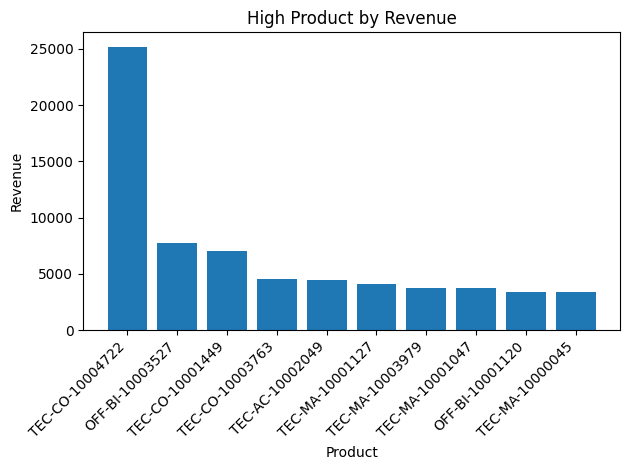

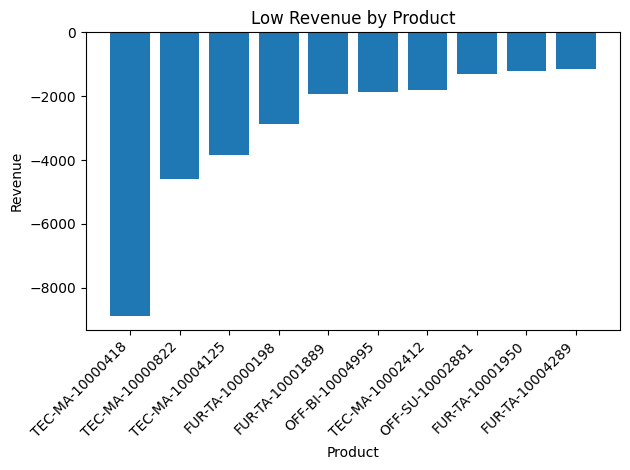

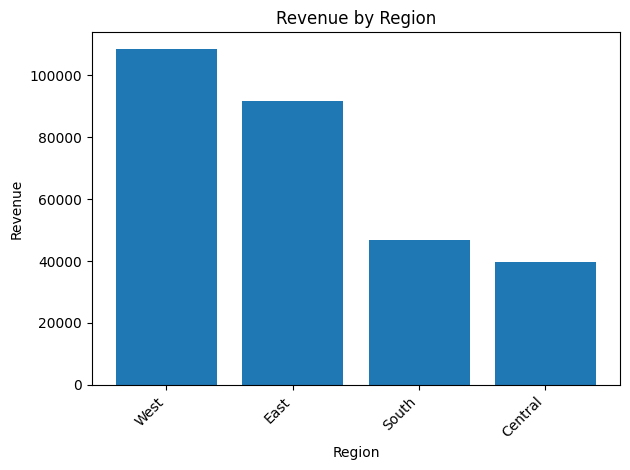

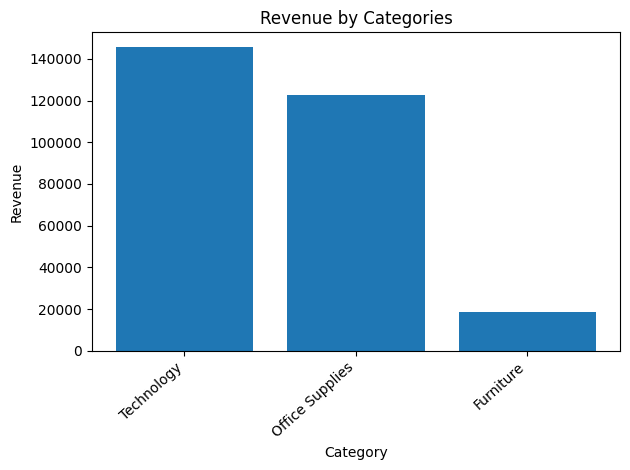

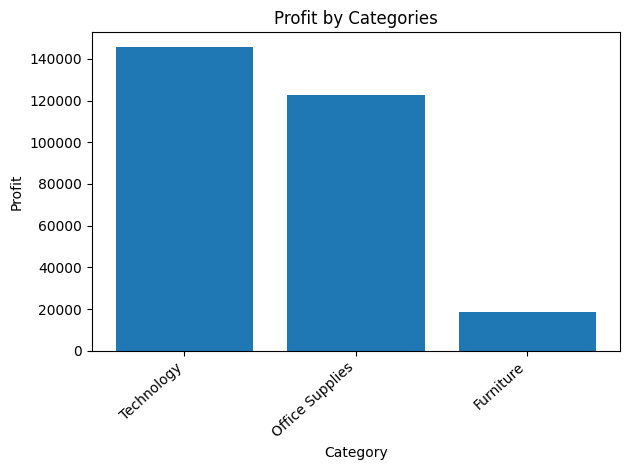

{'High Revenue by Product': 'outputs_sales\\high_prod_revenue.png',
 'Low Revenue by Product': 'outputs_sales\\low_prod_revenue.png',
 'Region by Revenue': 'outputs_sales\\region_revenue.png',
 'REvenue by Category': 'outputs_sales\\Revenueby_category.png',
 'Profit by Category': 'outputs_sales\\Profit_by_category.png'}

In [143]:
chart_paths = make_chart(df_featu, OUTPUT_DIR)
chart_paths

In [144]:
clean_path = os.path.join(OUTPUT_DIR, "sales_cleaned.csv")
df_featu.to_csv(clean_path, index=False)
print('Saved:', clean_path)


Saved: outputs_sales\sales_cleaned.csv


In [ ]:
# excel_path = os.path.join(OUTPUT_DIR, "sales_cleaned_tab.xlsx")

# with pd.ExcelWriter(excel_path) as writer:
#     df_featu.to_excel(writer, sheet_name="CleanedData", index=False)

# print("Saved:", excel_path)


In [145]:
# Confirm chart files saved
print('Saved chart files:')
for k, v in chart_paths.items():
    print('-', k, '->', v)


Saved chart files:
- High Revenue by Product -> outputs_sales\high_prod_revenue.png
- Low Revenue by Product -> outputs_sales\low_prod_revenue.png
- Region by Revenue -> outputs_sales\region_revenue.png
- REvenue by Category -> outputs_sales\Revenueby_category.png
- Profit by Category -> outputs_sales\Profit_by_category.png
